<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB4] - Data augmentation 
<!-- DESC --> Episode 4 : Adding data by data augmentation when we lack it, to improve our results
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Trying to improve training by **enhancing the data**
  - Using Keras' **data augmentation utilities**, finding their limits...
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


## What we're going to do :
 - Increase and improve the training dataset
 - Identify the limits of these tools

## Step 1 - Import and init
### 1.1 - Python stuffs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB4.001'
datasets_dir = pwk.init('GTSRB4', run_dir)

**\*\* Overrided parameters : \*\***

run_dir              : ./run/GTSRB4_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.7
Notebook id          : GTSRB4
Run time             : Wednesday 27 January 2021, 18:28:54
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/GTSRB4_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB4_done/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  

In [2]:
enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'
dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 5
scale        = 1

enhanced_dir = './data'

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale')

**\*\* Overrided parameters : \*\***

enhanced_dir         : /gpfswork/rech/mlh/uja62cb/datasets/GTSRB/enhanced
dataset_name         : set-24x24-L
batch_size           : 64
epochs               : 5
scale                : 1


## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [4]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)


Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:00 198ms)


## Step 3 - Models
We will now build a model and train it...

This is my model ;-) 

In [5]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

## Step 4 - Callbacks  
We prepare 2 kind callbacks :  TensorBoard and Model backup

In [6]:
pwk.mkdir(run_dir + '/models')
pwk.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + pwk.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

print(f'To run tensorboard, use :  --logdir {run_dir}/logs')

To run tensorboard, use :  --logdir ./run/GTSRB4_done/logs


## Step 5 - Data augmentation

In [7]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
datagen.fit(x_train)

## Step 6 - Train the model
**Get my data shape :**

In [8]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [9]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :** 

In [10]:
pwk.chrono_start()

history = model.fit(  datagen.flow(x_train, y_train, batch_size=batch_size),
                      steps_per_epoch = int(x_train.shape[0]/batch_size),
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

pwk.chrono_show()

Epoch 1/5


  1/612 [..............................] - ETA: 0s - loss: 3.7833 - accuracy: 0.0156

  3/612 [..............................] - ETA: 10s - loss: 3.6842 - accuracy: 0.0573

  7/612 [..............................] - ETA: 9s - loss: 3.6570 - accuracy: 0.0446 

 11/612 [..............................] - ETA: 9s - loss: 3.6360 - accuracy: 0.0426

 15/612 [..............................] - ETA: 9s - loss: 3.6182 - accuracy: 0.0500

 19/612 [..............................] - ETA: 8s - loss: 3.6177 - accuracy: 0.0485

 23/612 [>.............................] - ETA: 8s - loss: 3.6025 - accuracy: 0.0496

 27/612 [>.............................] - ETA: 8s - loss: 3.5950 - accuracy: 0.0486

 31/612 [>.............................] - ETA: 8s - loss: 3.5862 - accuracy: 0.0489

 35/612 [>.............................] - ETA: 8s - loss: 3.5794 - accuracy: 0.0482

 39/612 [>.............................] - ETA: 8s - loss: 3.5669 - accuracy: 0.0501

 43/612 [=>............................] - ETA: 8s - loss: 3.5638 - accuracy: 0.0516

 47/612 [=>............................] - ETA: 8s - loss: 3.5622 - accuracy: 0.0532

 51/612 [=>............................] - ETA: 8s - loss: 3.5532 - accuracy: 0.0545

 55/612 [=>............................] - ETA: 8s - loss: 3.5412 - accuracy: 0.0557

 59/612 [=>............................] - ETA: 8s - loss: 3.5368 - accuracy: 0.0551

 63/612 [==>...........................] - ETA: 8s - loss: 3.5271 - accuracy: 0.0565

 67/612 [==>...........................] - ETA: 8s - loss: 3.5233 - accuracy: 0.0581

 71/612 [==>...........................] - ETA: 7s - loss: 3.5197 - accuracy: 0.0592

 75/612 [==>...........................] - ETA: 7s - loss: 3.5091 - accuracy: 0.0619

 79/612 [==>...........................] - ETA: 7s - loss: 3.5037 - accuracy: 0.0633

 83/612 [===>..........................] - ETA: 7s - loss: 3.4955 - accuracy: 0.0651

 87/612 [===>..........................] - ETA: 7s - loss: 3.4880 - accuracy: 0.0684

 91/612 [===>..........................] - ETA: 7s - loss: 3.4760 - accuracy: 0.0701

 95/612 [===>..........................] - ETA: 7s - loss: 3.4681 - accuracy: 0.0707

 99/612 [===>..........................] - ETA: 7s - loss: 3.4609 - accuracy: 0.0715

103/612 [====>.........................] - ETA: 7s - loss: 3.4559 - accuracy: 0.0725

107/612 [====>.........................] - ETA: 7s - loss: 3.4484 - accuracy: 0.0749

111/612 [====>.........................] - ETA: 7s - loss: 3.4397 - accuracy: 0.0767

115/612 [====>.........................] - ETA: 7s - loss: 3.4293 - accuracy: 0.0799

119/612 [====>.........................] - ETA: 7s - loss: 3.4200 - accuracy: 0.0821

123/612 [=====>........................] - ETA: 7s - loss: 3.4129 - accuracy: 0.0842

127/612 [=====>........................] - ETA: 7s - loss: 3.4069 - accuracy: 0.0872

131/612 [=====>........................] - ETA: 7s - loss: 3.3992 - accuracy: 0.0892

135/612 [=====>........................] - ETA: 6s - loss: 3.3895 - accuracy: 0.0935

139/612 [=====>........................] - ETA: 6s - loss: 3.3829 - accuracy: 0.0963

143/612 [======>.......................] - ETA: 6s - loss: 3.3716 - accuracy: 0.0987

147/612 [======>.......................] - ETA: 6s - loss: 3.3633 - accuracy: 0.1009

151/612 [======>.......................] - ETA: 6s - loss: 3.3538 - accuracy: 0.1037

155/612 [======>.......................] - ETA: 6s - loss: 3.3431 - accuracy: 0.1065

159/612 [======>.......................] - ETA: 6s - loss: 3.3353 - accuracy: 0.1095

163/612 [======>.......................] - ETA: 6s - loss: 3.3244 - accuracy: 0.1124

167/612 [=======>......................] - ETA: 6s - loss: 3.3136 - accuracy: 0.1146

171/612 [=======>......................] - ETA: 6s - loss: 3.3024 - accuracy: 0.1171

175/612 [=======>......................] - ETA: 6s - loss: 3.2870 - accuracy: 0.1204

179/612 [=======>......................] - ETA: 6s - loss: 3.2759 - accuracy: 0.1225

183/612 [=======>......................] - ETA: 6s - loss: 3.2620 - accuracy: 0.1261

187/612 [========>.....................] - ETA: 6s - loss: 3.2496 - accuracy: 0.1301

191/612 [========>.....................] - ETA: 6s - loss: 3.2375 - accuracy: 0.1332

195/612 [========>.....................] - ETA: 6s - loss: 3.2275 - accuracy: 0.1357

199/612 [========>.....................] - ETA: 6s - loss: 3.2162 - accuracy: 0.1389

203/612 [========>.....................] - ETA: 5s - loss: 3.2023 - accuracy: 0.1422

207/612 [=========>....................] - ETA: 5s - loss: 3.1862 - accuracy: 0.1471

211/612 [=========>....................] - ETA: 5s - loss: 3.1742 - accuracy: 0.1500

215/612 [=========>....................] - ETA: 5s - loss: 3.1588 - accuracy: 0.1541

219/612 [=========>....................] - ETA: 5s - loss: 3.1439 - accuracy: 0.1571

223/612 [=========>....................] - ETA: 5s - loss: 3.1294 - accuracy: 0.1602

227/612 [==========>...................] - ETA: 5s - loss: 3.1167 - accuracy: 0.1633

231/612 [==========>...................] - ETA: 5s - loss: 3.1028 - accuracy: 0.1669

235/612 [==========>...................] - ETA: 5s - loss: 3.0868 - accuracy: 0.1709

239/612 [==========>...................] - ETA: 5s - loss: 3.0738 - accuracy: 0.1735

243/612 [==========>...................] - ETA: 5s - loss: 3.0605 - accuracy: 0.1769

247/612 [===========>..................] - ETA: 5s - loss: 3.0464 - accuracy: 0.1795

251/612 [===========>..................] - ETA: 5s - loss: 3.0342 - accuracy: 0.1821

255/612 [===========>..................] - ETA: 5s - loss: 3.0201 - accuracy: 0.1862

259/612 [===========>..................] - ETA: 5s - loss: 3.0065 - accuracy: 0.1891

263/612 [===========>..................] - ETA: 5s - loss: 2.9920 - accuracy: 0.1931

267/612 [============>.................] - ETA: 5s - loss: 2.9807 - accuracy: 0.1965

271/612 [============>.................] - ETA: 4s - loss: 2.9673 - accuracy: 0.1998

275/612 [============>.................] - ETA: 4s - loss: 2.9532 - accuracy: 0.2036

279/612 [============>.................] - ETA: 4s - loss: 2.9401 - accuracy: 0.2068

283/612 [============>.................] - ETA: 4s - loss: 2.9259 - accuracy: 0.2102

287/612 [=============>................] - ETA: 4s - loss: 2.9151 - accuracy: 0.2129

291/612 [=============>................] - ETA: 4s - loss: 2.9002 - accuracy: 0.2164

295/612 [=============>................] - ETA: 4s - loss: 2.8902 - accuracy: 0.2186

299/612 [=============>................] - ETA: 4s - loss: 2.8775 - accuracy: 0.2213

303/612 [=============>................] - ETA: 4s - loss: 2.8653 - accuracy: 0.2245

307/612 [==============>...............] - ETA: 4s - loss: 2.8533 - accuracy: 0.2275

311/612 [==============>...............] - ETA: 4s - loss: 2.8393 - accuracy: 0.2308

315/612 [==============>...............] - ETA: 4s - loss: 2.8258 - accuracy: 0.2334

319/612 [==============>...............] - ETA: 4s - loss: 2.8131 - accuracy: 0.2362

323/612 [==============>...............] - ETA: 4s - loss: 2.8015 - accuracy: 0.2391

327/612 [===============>..............] - ETA: 4s - loss: 2.7886 - accuracy: 0.2424

331/612 [===============>..............] - ETA: 4s - loss: 2.7773 - accuracy: 0.2453

335/612 [===============>..............] - ETA: 4s - loss: 2.7654 - accuracy: 0.2483

339/612 [===============>..............] - ETA: 3s - loss: 2.7555 - accuracy: 0.2506

343/612 [===============>..............] - ETA: 3s - loss: 2.7457 - accuracy: 0.2529

347/612 [================>.............] - ETA: 3s - loss: 2.7351 - accuracy: 0.2552

351/612 [================>.............] - ETA: 3s - loss: 2.7239 - accuracy: 0.2582

355/612 [================>.............] - ETA: 3s - loss: 2.7125 - accuracy: 0.2611

359/612 [================>.............] - ETA: 3s - loss: 2.7007 - accuracy: 0.2641

363/612 [================>.............] - ETA: 3s - loss: 2.6902 - accuracy: 0.2667

367/612 [================>.............] - ETA: 3s - loss: 2.6790 - accuracy: 0.2694

371/612 [=================>............] - ETA: 3s - loss: 2.6677 - accuracy: 0.2721

375/612 [=================>............] - ETA: 3s - loss: 2.6570 - accuracy: 0.2742

379/612 [=================>............] - ETA: 3s - loss: 2.6456 - accuracy: 0.2767

383/612 [=================>............] - ETA: 3s - loss: 2.6344 - accuracy: 0.2792

387/612 [=================>............] - ETA: 3s - loss: 2.6236 - accuracy: 0.2816

391/612 [==================>...........] - ETA: 3s - loss: 2.6133 - accuracy: 0.2837

395/612 [==================>...........] - ETA: 3s - loss: 2.6036 - accuracy: 0.2861

399/612 [==================>...........] - ETA: 3s - loss: 2.5935 - accuracy: 0.2887

403/612 [==================>...........] - ETA: 3s - loss: 2.5830 - accuracy: 0.2914

407/612 [==================>...........] - ETA: 2s - loss: 2.5717 - accuracy: 0.2942

411/612 [===================>..........] - ETA: 2s - loss: 2.5610 - accuracy: 0.2964

415/612 [===================>..........] - ETA: 2s - loss: 2.5534 - accuracy: 0.2981

419/612 [===================>..........] - ETA: 2s - loss: 2.5427 - accuracy: 0.3004

423/612 [===================>..........] - ETA: 2s - loss: 2.5332 - accuracy: 0.3025

427/612 [===================>..........] - ETA: 2s - loss: 2.5237 - accuracy: 0.3047

431/612 [====================>.........] - ETA: 2s - loss: 2.5141 - accuracy: 0.3070

435/612 [====================>.........] - ETA: 2s - loss: 2.5062 - accuracy: 0.3090

439/612 [====================>.........] - ETA: 2s - loss: 2.4963 - accuracy: 0.3115

443/612 [====================>.........] - ETA: 2s - loss: 2.4864 - accuracy: 0.3139

447/612 [====================>.........] - ETA: 2s - loss: 2.4777 - accuracy: 0.3160

451/612 [=====================>........] - ETA: 2s - loss: 2.4690 - accuracy: 0.3182

455/612 [=====================>........] - ETA: 2s - loss: 2.4610 - accuracy: 0.3206

459/612 [=====================>........] - ETA: 2s - loss: 2.4531 - accuracy: 0.3227

463/612 [=====================>........] - ETA: 2s - loss: 2.4436 - accuracy: 0.3249

467/612 [=====================>........] - ETA: 2s - loss: 2.4351 - accuracy: 0.3271

471/612 [======================>.......] - ETA: 2s - loss: 2.4258 - accuracy: 0.3292

475/612 [======================>.......] - ETA: 1s - loss: 2.4176 - accuracy: 0.3314

479/612 [======================>.......] - ETA: 1s - loss: 2.4087 - accuracy: 0.3335

483/612 [======================>.......] - ETA: 1s - loss: 2.3994 - accuracy: 0.3357

487/612 [======================>.......] - ETA: 1s - loss: 2.3917 - accuracy: 0.3374

491/612 [=======================>......] - ETA: 1s - loss: 2.3835 - accuracy: 0.3395

495/612 [=======================>......] - ETA: 1s - loss: 2.3753 - accuracy: 0.3417

499/612 [=======================>......] - ETA: 1s - loss: 2.3688 - accuracy: 0.3433

503/612 [=======================>......] - ETA: 1s - loss: 2.3615 - accuracy: 0.3452

507/612 [=======================>......] - ETA: 1s - loss: 2.3539 - accuracy: 0.3471

511/612 [========================>.....] - ETA: 1s - loss: 2.3473 - accuracy: 0.3487

515/612 [========================>.....] - ETA: 1s - loss: 2.3404 - accuracy: 0.3501

519/612 [========================>.....] - ETA: 1s - loss: 2.3320 - accuracy: 0.3520

523/612 [========================>.....] - ETA: 1s - loss: 2.3254 - accuracy: 0.3535

527/612 [========================>.....] - ETA: 1s - loss: 2.3173 - accuracy: 0.3554

531/612 [=========================>....] - ETA: 1s - loss: 2.3093 - accuracy: 0.3574

535/612 [=========================>....] - ETA: 1s - loss: 2.3017 - accuracy: 0.3594

540/612 [=========================>....] - ETA: 1s - loss: 2.2915 - accuracy: 0.3622

544/612 [=========================>....] - ETA: 1s - loss: 2.2851 - accuracy: 0.3636

548/612 [=========================>....] - ETA: 0s - loss: 2.2765 - accuracy: 0.3659

552/612 [==========================>...] - ETA: 0s - loss: 2.2702 - accuracy: 0.3673

556/612 [==========================>...] - ETA: 0s - loss: 2.2637 - accuracy: 0.3688

560/612 [==========================>...] - ETA: 0s - loss: 2.2572 - accuracy: 0.3704

564/612 [==========================>...] - ETA: 0s - loss: 2.2493 - accuracy: 0.3723

568/612 [==========================>...] - ETA: 0s - loss: 2.2421 - accuracy: 0.3740

572/612 [===========================>..] - ETA: 0s - loss: 2.2355 - accuracy: 0.3757

576/612 [===========================>..] - ETA: 0s - loss: 2.2290 - accuracy: 0.3774

580/612 [===========================>..] - ETA: 0s - loss: 2.2222 - accuracy: 0.3793

584/612 [===========================>..] - ETA: 0s - loss: 2.2157 - accuracy: 0.3811

588/612 [===========================>..] - ETA: 0s - loss: 2.2089 - accuracy: 0.3827

592/612 [============================>.] - ETA: 0s - loss: 2.2023 - accuracy: 0.3847

596/612 [============================>.] - ETA: 0s - loss: 2.1956 - accuracy: 0.3862

600/612 [============================>.] - ETA: 0s - loss: 2.1897 - accuracy: 0.3876

604/612 [============================>.] - ETA: 0s - loss: 2.1826 - accuracy: 0.3894

608/612 [============================>.] - ETA: 0s - loss: 2.1762 - accuracy: 0.3911

612/612 [==============================] - ETA: 0s - loss: 2.1699 - accuracy: 0.3926

612/612 [==============================] - 11s 18ms/step - loss: 2.1699 - accuracy: 0.3926 - val_loss: 0.8277 - val_accuracy: 0.7641


Epoch 2/5
  1/612 [..............................] - ETA: 0s - loss: 1.0006 - accuracy: 0.7656

  5/612 [..............................] - ETA: 7s - loss: 1.1898 - accuracy: 0.6500

  9/612 [..............................] - ETA: 8s - loss: 1.1749 - accuracy: 0.6545

 13/612 [..............................] - ETA: 8s - loss: 1.1949 - accuracy: 0.6526

 17/612 [..............................] - ETA: 8s - loss: 1.1930 - accuracy: 0.6553

 21/612 [>.............................] - ETA: 8s - loss: 1.2017 - accuracy: 0.6488

 25/612 [>.............................] - ETA: 8s - loss: 1.2001 - accuracy: 0.6475

 29/612 [>.............................] - ETA: 8s - loss: 1.1885 - accuracy: 0.6482

 33/612 [>.............................] - ETA: 8s - loss: 1.1804 - accuracy: 0.6496

 37/612 [>.............................] - ETA: 8s - loss: 1.1823 - accuracy: 0.6461

 41/612 [=>............................] - ETA: 8s - loss: 1.1703 - accuracy: 0.6463

 45/612 [=>............................] - ETA: 8s - loss: 1.1692 - accuracy: 0.6444

 49/612 [=>............................] - ETA: 8s - loss: 1.1679 - accuracy: 0.6429

 53/612 [=>............................] - ETA: 8s - loss: 1.1571 - accuracy: 0.6448

 57/612 [=>............................] - ETA: 8s - loss: 1.1539 - accuracy: 0.6456

 61/612 [=>............................] - ETA: 8s - loss: 1.1460 - accuracy: 0.6473

 65/612 [==>...........................] - ETA: 8s - loss: 1.1448 - accuracy: 0.6488

 69/612 [==>...........................] - ETA: 7s - loss: 1.1420 - accuracy: 0.6506

 73/612 [==>...........................] - ETA: 7s - loss: 1.1421 - accuracy: 0.6503

 77/612 [==>...........................] - ETA: 7s - loss: 1.1380 - accuracy: 0.6516

 81/612 [==>...........................] - ETA: 7s - loss: 1.1350 - accuracy: 0.6528

 85/612 [===>..........................] - ETA: 7s - loss: 1.1334 - accuracy: 0.6542

 89/612 [===>..........................] - ETA: 7s - loss: 1.1278 - accuracy: 0.6587

 93/612 [===>..........................] - ETA: 7s - loss: 1.1269 - accuracy: 0.6598

 97/612 [===>..........................] - ETA: 7s - loss: 1.1239 - accuracy: 0.6611

101/612 [===>..........................] - ETA: 7s - loss: 1.1237 - accuracy: 0.6610

105/612 [====>.........................] - ETA: 7s - loss: 1.1196 - accuracy: 0.6619

109/612 [====>.........................] - ETA: 7s - loss: 1.1191 - accuracy: 0.6624

113/612 [====>.........................] - ETA: 7s - loss: 1.1177 - accuracy: 0.6629

117/612 [====>.........................] - ETA: 7s - loss: 1.1175 - accuracy: 0.6640

121/612 [====>.........................] - ETA: 7s - loss: 1.1130 - accuracy: 0.6665

125/612 [=====>........................] - ETA: 7s - loss: 1.1134 - accuracy: 0.6662

129/612 [=====>........................] - ETA: 7s - loss: 1.1081 - accuracy: 0.6680

133/612 [=====>........................] - ETA: 7s - loss: 1.1079 - accuracy: 0.6675

137/612 [=====>........................] - ETA: 6s - loss: 1.1048 - accuracy: 0.6693

141/612 [=====>........................] - ETA: 6s - loss: 1.1023 - accuracy: 0.6694

145/612 [======>.......................] - ETA: 6s - loss: 1.1006 - accuracy: 0.6703

149/612 [======>.......................] - ETA: 6s - loss: 1.0964 - accuracy: 0.6717

153/612 [======>.......................] - ETA: 6s - loss: 1.0961 - accuracy: 0.6725

157/612 [======>.......................] - ETA: 6s - loss: 1.0958 - accuracy: 0.6725

161/612 [======>.......................] - ETA: 6s - loss: 1.0934 - accuracy: 0.6728

165/612 [=======>......................] - ETA: 6s - loss: 1.0919 - accuracy: 0.6731

169/612 [=======>......................] - ETA: 6s - loss: 1.0939 - accuracy: 0.6727

173/612 [=======>......................] - ETA: 6s - loss: 1.0925 - accuracy: 0.6731

177/612 [=======>......................] - ETA: 6s - loss: 1.0893 - accuracy: 0.6738

181/612 [=======>......................] - ETA: 6s - loss: 1.0893 - accuracy: 0.6738

185/612 [========>.....................] - ETA: 6s - loss: 1.0864 - accuracy: 0.6742

189/612 [========>.....................] - ETA: 6s - loss: 1.0853 - accuracy: 0.6742

193/612 [========>.....................] - ETA: 6s - loss: 1.0820 - accuracy: 0.6752

197/612 [========>.....................] - ETA: 6s - loss: 1.0812 - accuracy: 0.6751

201/612 [========>.....................] - ETA: 6s - loss: 1.0808 - accuracy: 0.6753

205/612 [=========>....................] - ETA: 5s - loss: 1.0793 - accuracy: 0.6756

209/612 [=========>....................] - ETA: 5s - loss: 1.0768 - accuracy: 0.6763

213/612 [=========>....................] - ETA: 5s - loss: 1.0763 - accuracy: 0.6766

217/612 [=========>....................] - ETA: 5s - loss: 1.0754 - accuracy: 0.6771

221/612 [=========>....................] - ETA: 5s - loss: 1.0729 - accuracy: 0.6782

225/612 [==========>...................] - ETA: 5s - loss: 1.0691 - accuracy: 0.6792

229/612 [==========>...................] - ETA: 5s - loss: 1.0664 - accuracy: 0.6799

233/612 [==========>...................] - ETA: 5s - loss: 1.0641 - accuracy: 0.6809

237/612 [==========>...................] - ETA: 5s - loss: 1.0629 - accuracy: 0.6810

241/612 [==========>...................] - ETA: 5s - loss: 1.0615 - accuracy: 0.6811

245/612 [===========>..................] - ETA: 5s - loss: 1.0594 - accuracy: 0.6823

249/612 [===========>..................] - ETA: 5s - loss: 1.0581 - accuracy: 0.6831

253/612 [===========>..................] - ETA: 5s - loss: 1.0559 - accuracy: 0.6839

257/612 [===========>..................] - ETA: 5s - loss: 1.0533 - accuracy: 0.6848

261/612 [===========>..................] - ETA: 5s - loss: 1.0512 - accuracy: 0.6853

265/612 [===========>..................] - ETA: 5s - loss: 1.0490 - accuracy: 0.6858

269/612 [============>.................] - ETA: 5s - loss: 1.0462 - accuracy: 0.6865

273/612 [============>.................] - ETA: 4s - loss: 1.0453 - accuracy: 0.6872

277/612 [============>.................] - ETA: 4s - loss: 1.0438 - accuracy: 0.6875

281/612 [============>.................] - ETA: 4s - loss: 1.0421 - accuracy: 0.6877

285/612 [============>.................] - ETA: 4s - loss: 1.0401 - accuracy: 0.6881

289/612 [=============>................] - ETA: 4s - loss: 1.0388 - accuracy: 0.6887

293/612 [=============>................] - ETA: 4s - loss: 1.0363 - accuracy: 0.6892

297/612 [=============>................] - ETA: 4s - loss: 1.0342 - accuracy: 0.6900

301/612 [=============>................] - ETA: 4s - loss: 1.0326 - accuracy: 0.6907

305/612 [=============>................] - ETA: 4s - loss: 1.0303 - accuracy: 0.6913

309/612 [==============>...............] - ETA: 4s - loss: 1.0285 - accuracy: 0.6914

313/612 [==============>...............] - ETA: 4s - loss: 1.0268 - accuracy: 0.6913

317/612 [==============>...............] - ETA: 4s - loss: 1.0256 - accuracy: 0.6915

321/612 [==============>...............] - ETA: 4s - loss: 1.0245 - accuracy: 0.6919

325/612 [==============>...............] - ETA: 4s - loss: 1.0229 - accuracy: 0.6924

329/612 [===============>..............] - ETA: 4s - loss: 1.0221 - accuracy: 0.6925

333/612 [===============>..............] - ETA: 4s - loss: 1.0217 - accuracy: 0.6927

337/612 [===============>..............] - ETA: 4s - loss: 1.0190 - accuracy: 0.6935

341/612 [===============>..............] - ETA: 3s - loss: 1.0181 - accuracy: 0.6937

345/612 [===============>..............] - ETA: 3s - loss: 1.0152 - accuracy: 0.6947

349/612 [================>.............] - ETA: 3s - loss: 1.0144 - accuracy: 0.6947

353/612 [================>.............] - ETA: 3s - loss: 1.0126 - accuracy: 0.6950

357/612 [================>.............] - ETA: 3s - loss: 1.0098 - accuracy: 0.6959

361/612 [================>.............] - ETA: 3s - loss: 1.0078 - accuracy: 0.6964

365/612 [================>.............] - ETA: 3s - loss: 1.0064 - accuracy: 0.6969

369/612 [=================>............] - ETA: 3s - loss: 1.0046 - accuracy: 0.6972

373/612 [=================>............] - ETA: 3s - loss: 1.0027 - accuracy: 0.6977

377/612 [=================>............] - ETA: 3s - loss: 1.0018 - accuracy: 0.6975

381/612 [=================>............] - ETA: 3s - loss: 0.9997 - accuracy: 0.6982

385/612 [=================>............] - ETA: 3s - loss: 0.9975 - accuracy: 0.6987

389/612 [==================>...........] - ETA: 3s - loss: 0.9953 - accuracy: 0.6995

393/612 [==================>...........] - ETA: 3s - loss: 0.9932 - accuracy: 0.6998

397/612 [==================>...........] - ETA: 3s - loss: 0.9908 - accuracy: 0.7001

401/612 [==================>...........] - ETA: 3s - loss: 0.9883 - accuracy: 0.7009

405/612 [==================>...........] - ETA: 3s - loss: 0.9860 - accuracy: 0.7019

409/612 [===================>..........] - ETA: 2s - loss: 0.9844 - accuracy: 0.7021

413/612 [===================>..........] - ETA: 2s - loss: 0.9819 - accuracy: 0.7027

417/612 [===================>..........] - ETA: 2s - loss: 0.9807 - accuracy: 0.7029

421/612 [===================>..........] - ETA: 2s - loss: 0.9799 - accuracy: 0.7033

425/612 [===================>..........] - ETA: 2s - loss: 0.9773 - accuracy: 0.7043

429/612 [====================>.........] - ETA: 2s - loss: 0.9761 - accuracy: 0.7047

433/612 [====================>.........] - ETA: 2s - loss: 0.9753 - accuracy: 0.7047

437/612 [====================>.........] - ETA: 2s - loss: 0.9731 - accuracy: 0.7051

441/612 [====================>.........] - ETA: 2s - loss: 0.9727 - accuracy: 0.7053

445/612 [====================>.........] - ETA: 2s - loss: 0.9715 - accuracy: 0.7057

449/612 [=====================>........] - ETA: 2s - loss: 0.9721 - accuracy: 0.7058

453/612 [=====================>........] - ETA: 2s - loss: 0.9711 - accuracy: 0.7060

457/612 [=====================>........] - ETA: 2s - loss: 0.9693 - accuracy: 0.7065

461/612 [=====================>........] - ETA: 2s - loss: 0.9672 - accuracy: 0.7071

465/612 [=====================>........] - ETA: 2s - loss: 0.9655 - accuracy: 0.7075

469/612 [=====================>........] - ETA: 2s - loss: 0.9651 - accuracy: 0.7075

473/612 [======================>.......] - ETA: 2s - loss: 0.9641 - accuracy: 0.7079

477/612 [======================>.......] - ETA: 1s - loss: 0.9621 - accuracy: 0.7085

481/612 [======================>.......] - ETA: 1s - loss: 0.9608 - accuracy: 0.7092

485/612 [======================>.......] - ETA: 1s - loss: 0.9603 - accuracy: 0.7093

489/612 [======================>.......] - ETA: 1s - loss: 0.9584 - accuracy: 0.7099

493/612 [=======================>......] - ETA: 1s - loss: 0.9573 - accuracy: 0.7101

497/612 [=======================>......] - ETA: 1s - loss: 0.9559 - accuracy: 0.7103

501/612 [=======================>......] - ETA: 1s - loss: 0.9553 - accuracy: 0.7106

505/612 [=======================>......] - ETA: 1s - loss: 0.9532 - accuracy: 0.7110

509/612 [=======================>......] - ETA: 1s - loss: 0.9517 - accuracy: 0.7114

513/612 [========================>.....] - ETA: 1s - loss: 0.9501 - accuracy: 0.7120

517/612 [========================>.....] - ETA: 1s - loss: 0.9489 - accuracy: 0.7122

521/612 [========================>.....] - ETA: 1s - loss: 0.9487 - accuracy: 0.7122

525/612 [========================>.....] - ETA: 1s - loss: 0.9468 - accuracy: 0.7129

529/612 [========================>.....] - ETA: 1s - loss: 0.9452 - accuracy: 0.7134

533/612 [=========================>....] - ETA: 1s - loss: 0.9441 - accuracy: 0.7138

537/612 [=========================>....] - ETA: 1s - loss: 0.9425 - accuracy: 0.7144

541/612 [=========================>....] - ETA: 1s - loss: 0.9420 - accuracy: 0.7144

545/612 [=========================>....] - ETA: 0s - loss: 0.9407 - accuracy: 0.7149

549/612 [=========================>....] - ETA: 0s - loss: 0.9402 - accuracy: 0.7152

553/612 [==========================>...] - ETA: 0s - loss: 0.9391 - accuracy: 0.7153

557/612 [==========================>...] - ETA: 0s - loss: 0.9372 - accuracy: 0.7156

561/612 [==========================>...] - ETA: 0s - loss: 0.9352 - accuracy: 0.7163

565/612 [==========================>...] - ETA: 0s - loss: 0.9337 - accuracy: 0.7168

569/612 [==========================>...] - ETA: 0s - loss: 0.9327 - accuracy: 0.7169

573/612 [===========================>..] - ETA: 0s - loss: 0.9312 - accuracy: 0.7172

577/612 [===========================>..] - ETA: 0s - loss: 0.9298 - accuracy: 0.7178

581/612 [===========================>..] - ETA: 0s - loss: 0.9281 - accuracy: 0.7183

585/612 [===========================>..] - ETA: 0s - loss: 0.9264 - accuracy: 0.7189

589/612 [===========================>..] - ETA: 0s - loss: 0.9249 - accuracy: 0.7194

593/612 [============================>.] - ETA: 0s - loss: 0.9240 - accuracy: 0.7197

597/612 [============================>.] - ETA: 0s - loss: 0.9217 - accuracy: 0.7204

601/612 [============================>.] - ETA: 0s - loss: 0.9213 - accuracy: 0.7206

605/612 [============================>.] - ETA: 0s - loss: 0.9200 - accuracy: 0.7209

609/612 [============================>.] - ETA: 0s - loss: 0.9192 - accuracy: 0.7211

612/612 [==============================] - 10s 17ms/step - loss: 0.9186 - accuracy: 0.7212 - val_loss: 0.4865 - val_accuracy: 0.8524


Epoch 3/5
  1/612 [..............................] - ETA: 0s - loss: 0.6925 - accuracy: 0.8125

  5/612 [..............................] - ETA: 7s - loss: 0.7342 - accuracy: 0.7906

  9/612 [..............................] - ETA: 8s - loss: 0.7428 - accuracy: 0.7812

 13/612 [..............................] - ETA: 8s - loss: 0.7410 - accuracy: 0.7825

 17/612 [..............................] - ETA: 8s - loss: 0.7621 - accuracy: 0.7822

 21/612 [>.............................] - ETA: 8s - loss: 0.7476 - accuracy: 0.7798

 25/612 [>.............................] - ETA: 8s - loss: 0.7302 - accuracy: 0.7800

 29/612 [>.............................] - ETA: 8s - loss: 0.7260 - accuracy: 0.7747

 33/612 [>.............................] - ETA: 8s - loss: 0.7249 - accuracy: 0.7745

 37/612 [>.............................] - ETA: 8s - loss: 0.7260 - accuracy: 0.7774

 41/612 [=>............................] - ETA: 8s - loss: 0.7275 - accuracy: 0.7759

 45/612 [=>............................] - ETA: 8s - loss: 0.7293 - accuracy: 0.7746

 49/612 [=>............................] - ETA: 8s - loss: 0.7203 - accuracy: 0.7780

 53/612 [=>............................] - ETA: 8s - loss: 0.7190 - accuracy: 0.7786

 57/612 [=>............................] - ETA: 8s - loss: 0.7228 - accuracy: 0.7766

 61/612 [=>............................] - ETA: 8s - loss: 0.7269 - accuracy: 0.7753

 65/612 [==>...........................] - ETA: 8s - loss: 0.7221 - accuracy: 0.7781

 69/612 [==>...........................] - ETA: 7s - loss: 0.7196 - accuracy: 0.7796

 73/612 [==>...........................] - ETA: 7s - loss: 0.7174 - accuracy: 0.7791

 77/612 [==>...........................] - ETA: 7s - loss: 0.7146 - accuracy: 0.7796

 81/612 [==>...........................] - ETA: 7s - loss: 0.7128 - accuracy: 0.7805

 85/612 [===>..........................] - ETA: 7s - loss: 0.7136 - accuracy: 0.7800

 89/612 [===>..........................] - ETA: 7s - loss: 0.7163 - accuracy: 0.7791

 93/612 [===>..........................] - ETA: 7s - loss: 0.7158 - accuracy: 0.7782

 97/612 [===>..........................] - ETA: 7s - loss: 0.7114 - accuracy: 0.7793

101/612 [===>..........................] - ETA: 7s - loss: 0.7101 - accuracy: 0.7797

105/612 [====>.........................] - ETA: 7s - loss: 0.7102 - accuracy: 0.7783

109/612 [====>.........................] - ETA: 7s - loss: 0.7124 - accuracy: 0.7775

113/612 [====>.........................] - ETA: 7s - loss: 0.7077 - accuracy: 0.7796

117/612 [====>.........................] - ETA: 7s - loss: 0.7097 - accuracy: 0.7786

121/612 [====>.........................] - ETA: 7s - loss: 0.7116 - accuracy: 0.7783

125/612 [=====>........................] - ETA: 7s - loss: 0.7092 - accuracy: 0.7806

129/612 [=====>........................] - ETA: 7s - loss: 0.7085 - accuracy: 0.7808

133/612 [=====>........................] - ETA: 7s - loss: 0.7064 - accuracy: 0.7808

137/612 [=====>........................] - ETA: 7s - loss: 0.7038 - accuracy: 0.7816

141/612 [=====>........................] - ETA: 6s - loss: 0.7071 - accuracy: 0.7809

145/612 [======>.......................] - ETA: 6s - loss: 0.7058 - accuracy: 0.7812

149/612 [======>.......................] - ETA: 6s - loss: 0.7052 - accuracy: 0.7812

153/612 [======>.......................] - ETA: 6s - loss: 0.7036 - accuracy: 0.7821

157/612 [======>.......................] - ETA: 6s - loss: 0.7053 - accuracy: 0.7817

161/612 [======>.......................] - ETA: 6s - loss: 0.7028 - accuracy: 0.7824

165/612 [=======>......................] - ETA: 6s - loss: 0.7022 - accuracy: 0.7820

169/612 [=======>......................] - ETA: 6s - loss: 0.6990 - accuracy: 0.7832

173/612 [=======>......................] - ETA: 6s - loss: 0.6976 - accuracy: 0.7837

177/612 [=======>......................] - ETA: 6s - loss: 0.6952 - accuracy: 0.7846

181/612 [=======>......................] - ETA: 6s - loss: 0.6919 - accuracy: 0.7851

185/612 [========>.....................] - ETA: 6s - loss: 0.6900 - accuracy: 0.7858

189/612 [========>.....................] - ETA: 6s - loss: 0.6877 - accuracy: 0.7870

193/612 [========>.....................] - ETA: 6s - loss: 0.6847 - accuracy: 0.7877

197/612 [========>.....................] - ETA: 6s - loss: 0.6850 - accuracy: 0.7875

201/612 [========>.....................] - ETA: 6s - loss: 0.6822 - accuracy: 0.7883

205/612 [=========>....................] - ETA: 6s - loss: 0.6799 - accuracy: 0.7895

209/612 [=========>....................] - ETA: 5s - loss: 0.6799 - accuracy: 0.7894

213/612 [=========>....................] - ETA: 5s - loss: 0.6786 - accuracy: 0.7897

217/612 [=========>....................] - ETA: 5s - loss: 0.6772 - accuracy: 0.7899

221/612 [=========>....................] - ETA: 5s - loss: 0.6759 - accuracy: 0.7902

225/612 [==========>...................] - ETA: 5s - loss: 0.6743 - accuracy: 0.7908

229/612 [==========>...................] - ETA: 5s - loss: 0.6738 - accuracy: 0.7910

233/612 [==========>...................] - ETA: 5s - loss: 0.6730 - accuracy: 0.7909

237/612 [==========>...................] - ETA: 5s - loss: 0.6720 - accuracy: 0.7912

241/612 [==========>...................] - ETA: 5s - loss: 0.6708 - accuracy: 0.7916

245/612 [===========>..................] - ETA: 5s - loss: 0.6700 - accuracy: 0.7917

249/612 [===========>..................] - ETA: 5s - loss: 0.6711 - accuracy: 0.7917

253/612 [===========>..................] - ETA: 5s - loss: 0.6706 - accuracy: 0.7916

257/612 [===========>..................] - ETA: 5s - loss: 0.6708 - accuracy: 0.7916

261/612 [===========>..................] - ETA: 5s - loss: 0.6701 - accuracy: 0.7920

265/612 [===========>..................] - ETA: 5s - loss: 0.6720 - accuracy: 0.7910

269/612 [============>.................] - ETA: 5s - loss: 0.6720 - accuracy: 0.7908

273/612 [============>.................] - ETA: 5s - loss: 0.6706 - accuracy: 0.7915

277/612 [============>.................] - ETA: 4s - loss: 0.6705 - accuracy: 0.7917

281/612 [============>.................] - ETA: 4s - loss: 0.6714 - accuracy: 0.7912

285/612 [============>.................] - ETA: 4s - loss: 0.6712 - accuracy: 0.7909

289/612 [=============>................] - ETA: 4s - loss: 0.6722 - accuracy: 0.7908

293/612 [=============>................] - ETA: 4s - loss: 0.6729 - accuracy: 0.7910

297/612 [=============>................] - ETA: 4s - loss: 0.6733 - accuracy: 0.7909

301/612 [=============>................] - ETA: 4s - loss: 0.6720 - accuracy: 0.7909

305/612 [=============>................] - ETA: 4s - loss: 0.6708 - accuracy: 0.7911

309/612 [==============>...............] - ETA: 4s - loss: 0.6705 - accuracy: 0.7912

313/612 [==============>...............] - ETA: 4s - loss: 0.6689 - accuracy: 0.7916

317/612 [==============>...............] - ETA: 4s - loss: 0.6675 - accuracy: 0.7918

321/612 [==============>...............] - ETA: 4s - loss: 0.6674 - accuracy: 0.7920

325/612 [==============>...............] - ETA: 4s - loss: 0.6676 - accuracy: 0.7919

329/612 [===============>..............] - ETA: 4s - loss: 0.6660 - accuracy: 0.7922

333/612 [===============>..............] - ETA: 4s - loss: 0.6648 - accuracy: 0.7927

337/612 [===============>..............] - ETA: 4s - loss: 0.6642 - accuracy: 0.7927

341/612 [===============>..............] - ETA: 4s - loss: 0.6627 - accuracy: 0.7929

345/612 [===============>..............] - ETA: 3s - loss: 0.6616 - accuracy: 0.7932

349/612 [================>.............] - ETA: 3s - loss: 0.6602 - accuracy: 0.7938

353/612 [================>.............] - ETA: 3s - loss: 0.6590 - accuracy: 0.7943

357/612 [================>.............] - ETA: 3s - loss: 0.6570 - accuracy: 0.7950

361/612 [================>.............] - ETA: 3s - loss: 0.6560 - accuracy: 0.7955

365/612 [================>.............] - ETA: 3s - loss: 0.6566 - accuracy: 0.7955

369/612 [=================>............] - ETA: 3s - loss: 0.6557 - accuracy: 0.7955

373/612 [=================>............] - ETA: 3s - loss: 0.6557 - accuracy: 0.7954

377/612 [=================>............] - ETA: 3s - loss: 0.6546 - accuracy: 0.7959

381/612 [=================>............] - ETA: 3s - loss: 0.6533 - accuracy: 0.7961

385/612 [=================>............] - ETA: 3s - loss: 0.6529 - accuracy: 0.7962

389/612 [==================>...........] - ETA: 3s - loss: 0.6525 - accuracy: 0.7964

393/612 [==================>...........] - ETA: 3s - loss: 0.6519 - accuracy: 0.7966

397/612 [==================>...........] - ETA: 3s - loss: 0.6502 - accuracy: 0.7972

401/612 [==================>...........] - ETA: 3s - loss: 0.6496 - accuracy: 0.7973

405/612 [==================>...........] - ETA: 3s - loss: 0.6498 - accuracy: 0.7971

409/612 [===================>..........] - ETA: 3s - loss: 0.6488 - accuracy: 0.7977

413/612 [===================>..........] - ETA: 2s - loss: 0.6472 - accuracy: 0.7979

417/612 [===================>..........] - ETA: 2s - loss: 0.6467 - accuracy: 0.7983

421/612 [===================>..........] - ETA: 2s - loss: 0.6462 - accuracy: 0.7986

425/612 [===================>..........] - ETA: 2s - loss: 0.6457 - accuracy: 0.7987

429/612 [====================>.........] - ETA: 2s - loss: 0.6451 - accuracy: 0.7986

433/612 [====================>.........] - ETA: 2s - loss: 0.6444 - accuracy: 0.7987

437/612 [====================>.........] - ETA: 2s - loss: 0.6429 - accuracy: 0.7992

441/612 [====================>.........] - ETA: 2s - loss: 0.6425 - accuracy: 0.7994

445/612 [====================>.........] - ETA: 2s - loss: 0.6407 - accuracy: 0.8000

449/612 [=====================>........] - ETA: 2s - loss: 0.6398 - accuracy: 0.8005

453/612 [=====================>........] - ETA: 2s - loss: 0.6391 - accuracy: 0.8006

457/612 [=====================>........] - ETA: 2s - loss: 0.6396 - accuracy: 0.8005

461/612 [=====================>........] - ETA: 2s - loss: 0.6392 - accuracy: 0.8006

465/612 [=====================>........] - ETA: 2s - loss: 0.6393 - accuracy: 0.8007

469/612 [=====================>........] - ETA: 2s - loss: 0.6378 - accuracy: 0.8013

473/612 [======================>.......] - ETA: 2s - loss: 0.6373 - accuracy: 0.8016

477/612 [======================>.......] - ETA: 1s - loss: 0.6373 - accuracy: 0.8016

481/612 [======================>.......] - ETA: 1s - loss: 0.6370 - accuracy: 0.8019

485/612 [======================>.......] - ETA: 1s - loss: 0.6369 - accuracy: 0.8017

489/612 [======================>.......] - ETA: 1s - loss: 0.6371 - accuracy: 0.8016

493/612 [=======================>......] - ETA: 1s - loss: 0.6373 - accuracy: 0.8015

497/612 [=======================>......] - ETA: 1s - loss: 0.6366 - accuracy: 0.8016

501/612 [=======================>......] - ETA: 1s - loss: 0.6362 - accuracy: 0.8019

505/612 [=======================>......] - ETA: 1s - loss: 0.6360 - accuracy: 0.8020

509/612 [=======================>......] - ETA: 1s - loss: 0.6351 - accuracy: 0.8023

513/612 [========================>.....] - ETA: 1s - loss: 0.6341 - accuracy: 0.8027

517/612 [========================>.....] - ETA: 1s - loss: 0.6336 - accuracy: 0.8028

521/612 [========================>.....] - ETA: 1s - loss: 0.6324 - accuracy: 0.8032

525/612 [========================>.....] - ETA: 1s - loss: 0.6310 - accuracy: 0.8036

529/612 [========================>.....] - ETA: 1s - loss: 0.6303 - accuracy: 0.8040

533/612 [=========================>....] - ETA: 1s - loss: 0.6301 - accuracy: 0.8040

537/612 [=========================>....] - ETA: 1s - loss: 0.6291 - accuracy: 0.8042

541/612 [=========================>....] - ETA: 1s - loss: 0.6287 - accuracy: 0.8045

545/612 [=========================>....] - ETA: 0s - loss: 0.6282 - accuracy: 0.8048

549/612 [=========================>....] - ETA: 0s - loss: 0.6273 - accuracy: 0.8050

553/612 [==========================>...] - ETA: 0s - loss: 0.6277 - accuracy: 0.8047

557/612 [==========================>...] - ETA: 0s - loss: 0.6273 - accuracy: 0.8048

561/612 [==========================>...] - ETA: 0s - loss: 0.6268 - accuracy: 0.8049

565/612 [==========================>...] - ETA: 0s - loss: 0.6265 - accuracy: 0.8049

569/612 [==========================>...] - ETA: 0s - loss: 0.6257 - accuracy: 0.8050

573/612 [===========================>..] - ETA: 0s - loss: 0.6247 - accuracy: 0.8055

577/612 [===========================>..] - ETA: 0s - loss: 0.6241 - accuracy: 0.8057

581/612 [===========================>..] - ETA: 0s - loss: 0.6236 - accuracy: 0.8059

585/612 [===========================>..] - ETA: 0s - loss: 0.6234 - accuracy: 0.8060

589/612 [===========================>..] - ETA: 0s - loss: 0.6223 - accuracy: 0.8063

593/612 [============================>.] - ETA: 0s - loss: 0.6223 - accuracy: 0.8063

597/612 [============================>.] - ETA: 0s - loss: 0.6227 - accuracy: 0.8061

601/612 [============================>.] - ETA: 0s - loss: 0.6217 - accuracy: 0.8065

605/612 [============================>.] - ETA: 0s - loss: 0.6210 - accuracy: 0.8065

609/612 [============================>.] - ETA: 0s - loss: 0.6199 - accuracy: 0.8069

612/612 [==============================] - 10s 17ms/step - loss: 0.6197 - accuracy: 0.8070 - val_loss: 0.3410 - val_accuracy: 0.9083


Epoch 4/5
  1/612 [..............................] - ETA: 0s - loss: 0.4943 - accuracy: 0.8281

  5/612 [..............................] - ETA: 7s - loss: 0.5101 - accuracy: 0.8094

  9/612 [..............................] - ETA: 8s - loss: 0.5212 - accuracy: 0.8212

 13/612 [..............................] - ETA: 8s - loss: 0.5001 - accuracy: 0.8317

 17/612 [..............................] - ETA: 8s - loss: 0.5027 - accuracy: 0.8382

 21/612 [>.............................] - ETA: 8s - loss: 0.5100 - accuracy: 0.8371

 25/612 [>.............................] - ETA: 8s - loss: 0.5125 - accuracy: 0.8369

 29/612 [>.............................] - ETA: 8s - loss: 0.5276 - accuracy: 0.8330

 33/612 [>.............................] - ETA: 8s - loss: 0.5303 - accuracy: 0.8310

 37/612 [>.............................] - ETA: 8s - loss: 0.5354 - accuracy: 0.8319

 41/612 [=>............................] - ETA: 8s - loss: 0.5389 - accuracy: 0.8338

 45/612 [=>............................] - ETA: 8s - loss: 0.5412 - accuracy: 0.8326

 49/612 [=>............................] - ETA: 8s - loss: 0.5323 - accuracy: 0.8367

 53/612 [=>............................] - ETA: 8s - loss: 0.5348 - accuracy: 0.8343

 57/612 [=>............................] - ETA: 8s - loss: 0.5378 - accuracy: 0.8328

 61/612 [=>............................] - ETA: 8s - loss: 0.5431 - accuracy: 0.8322

 65/612 [==>...........................] - ETA: 7s - loss: 0.5445 - accuracy: 0.8315

 69/612 [==>...........................] - ETA: 7s - loss: 0.5398 - accuracy: 0.8340

 73/612 [==>...........................] - ETA: 7s - loss: 0.5431 - accuracy: 0.8326

 77/612 [==>...........................] - ETA: 7s - loss: 0.5453 - accuracy: 0.8320

 81/612 [==>...........................] - ETA: 7s - loss: 0.5419 - accuracy: 0.8345

 85/612 [===>..........................] - ETA: 7s - loss: 0.5422 - accuracy: 0.8346

 89/612 [===>..........................] - ETA: 7s - loss: 0.5395 - accuracy: 0.8360

 93/612 [===>..........................] - ETA: 7s - loss: 0.5345 - accuracy: 0.8370

 97/612 [===>..........................] - ETA: 7s - loss: 0.5315 - accuracy: 0.8378

101/612 [===>..........................] - ETA: 7s - loss: 0.5289 - accuracy: 0.8382

105/612 [====>.........................] - ETA: 7s - loss: 0.5286 - accuracy: 0.8382

109/612 [====>.........................] - ETA: 7s - loss: 0.5256 - accuracy: 0.8384

113/612 [====>.........................] - ETA: 7s - loss: 0.5240 - accuracy: 0.8388

117/612 [====>.........................] - ETA: 7s - loss: 0.5254 - accuracy: 0.8380

121/612 [====>.........................] - ETA: 7s - loss: 0.5240 - accuracy: 0.8385

125/612 [=====>........................] - ETA: 7s - loss: 0.5232 - accuracy: 0.8386

129/612 [=====>........................] - ETA: 7s - loss: 0.5228 - accuracy: 0.8395

133/612 [=====>........................] - ETA: 7s - loss: 0.5249 - accuracy: 0.8400

137/612 [=====>........................] - ETA: 6s - loss: 0.5250 - accuracy: 0.8398

141/612 [=====>........................] - ETA: 6s - loss: 0.5257 - accuracy: 0.8390

145/612 [======>.......................] - ETA: 6s - loss: 0.5228 - accuracy: 0.8398

149/612 [======>.......................] - ETA: 6s - loss: 0.5211 - accuracy: 0.8410

153/612 [======>.......................] - ETA: 6s - loss: 0.5205 - accuracy: 0.8406

157/612 [======>.......................] - ETA: 6s - loss: 0.5178 - accuracy: 0.8412

161/612 [======>.......................] - ETA: 6s - loss: 0.5178 - accuracy: 0.8413

165/612 [=======>......................] - ETA: 6s - loss: 0.5154 - accuracy: 0.8417

169/612 [=======>......................] - ETA: 6s - loss: 0.5147 - accuracy: 0.8421

173/612 [=======>......................] - ETA: 6s - loss: 0.5145 - accuracy: 0.8421

177/612 [=======>......................] - ETA: 6s - loss: 0.5162 - accuracy: 0.8421

181/612 [=======>......................] - ETA: 6s - loss: 0.5139 - accuracy: 0.8427

185/612 [========>.....................] - ETA: 6s - loss: 0.5133 - accuracy: 0.8427

189/612 [========>.....................] - ETA: 6s - loss: 0.5102 - accuracy: 0.8433

193/612 [========>.....................] - ETA: 6s - loss: 0.5097 - accuracy: 0.8436

197/612 [========>.....................] - ETA: 6s - loss: 0.5085 - accuracy: 0.8436

201/612 [========>.....................] - ETA: 6s - loss: 0.5065 - accuracy: 0.8440

205/612 [=========>....................] - ETA: 5s - loss: 0.5071 - accuracy: 0.8440

209/612 [=========>....................] - ETA: 5s - loss: 0.5061 - accuracy: 0.8446

213/612 [=========>....................] - ETA: 5s - loss: 0.5060 - accuracy: 0.8450

217/612 [=========>....................] - ETA: 5s - loss: 0.5041 - accuracy: 0.8454

221/612 [=========>....................] - ETA: 5s - loss: 0.5062 - accuracy: 0.8446

225/612 [==========>...................] - ETA: 5s - loss: 0.5057 - accuracy: 0.8442

229/612 [==========>...................] - ETA: 5s - loss: 0.5060 - accuracy: 0.8443

233/612 [==========>...................] - ETA: 5s - loss: 0.5063 - accuracy: 0.8444

237/612 [==========>...................] - ETA: 5s - loss: 0.5056 - accuracy: 0.8443

241/612 [==========>...................] - ETA: 5s - loss: 0.5056 - accuracy: 0.8439

245/612 [===========>..................] - ETA: 5s - loss: 0.5054 - accuracy: 0.8439

249/612 [===========>..................] - ETA: 5s - loss: 0.5045 - accuracy: 0.8440

253/612 [===========>..................] - ETA: 5s - loss: 0.5039 - accuracy: 0.8441

257/612 [===========>..................] - ETA: 5s - loss: 0.5036 - accuracy: 0.8439

261/612 [===========>..................] - ETA: 5s - loss: 0.5039 - accuracy: 0.8436

265/612 [===========>..................] - ETA: 5s - loss: 0.5023 - accuracy: 0.8443

269/612 [============>.................] - ETA: 5s - loss: 0.5040 - accuracy: 0.8439

273/612 [============>.................] - ETA: 4s - loss: 0.5037 - accuracy: 0.8442

277/612 [============>.................] - ETA: 4s - loss: 0.5036 - accuracy: 0.8444

281/612 [============>.................] - ETA: 4s - loss: 0.5031 - accuracy: 0.8449

285/612 [============>.................] - ETA: 4s - loss: 0.5039 - accuracy: 0.8448

289/612 [=============>................] - ETA: 4s - loss: 0.5036 - accuracy: 0.8448

293/612 [=============>................] - ETA: 4s - loss: 0.5032 - accuracy: 0.8450

297/612 [=============>................] - ETA: 4s - loss: 0.5021 - accuracy: 0.8453

301/612 [=============>................] - ETA: 4s - loss: 0.5025 - accuracy: 0.8453

305/612 [=============>................] - ETA: 4s - loss: 0.5019 - accuracy: 0.8456

309/612 [==============>...............] - ETA: 4s - loss: 0.5013 - accuracy: 0.8455

313/612 [==============>...............] - ETA: 4s - loss: 0.5004 - accuracy: 0.8459

317/612 [==============>...............] - ETA: 4s - loss: 0.4997 - accuracy: 0.8464

321/612 [==============>...............] - ETA: 4s - loss: 0.4992 - accuracy: 0.8463

325/612 [==============>...............] - ETA: 4s - loss: 0.4997 - accuracy: 0.8463

329/612 [===============>..............] - ETA: 4s - loss: 0.4996 - accuracy: 0.8465

333/612 [===============>..............] - ETA: 4s - loss: 0.4997 - accuracy: 0.8462

337/612 [===============>..............] - ETA: 4s - loss: 0.4992 - accuracy: 0.8462

341/612 [===============>..............] - ETA: 3s - loss: 0.4979 - accuracy: 0.8468

345/612 [===============>..............] - ETA: 3s - loss: 0.4970 - accuracy: 0.8472

349/612 [================>.............] - ETA: 3s - loss: 0.4965 - accuracy: 0.8472

353/612 [================>.............] - ETA: 3s - loss: 0.4973 - accuracy: 0.8468

357/612 [================>.............] - ETA: 3s - loss: 0.4967 - accuracy: 0.8469

361/612 [================>.............] - ETA: 3s - loss: 0.4957 - accuracy: 0.8475

365/612 [================>.............] - ETA: 3s - loss: 0.4944 - accuracy: 0.8480

369/612 [=================>............] - ETA: 3s - loss: 0.4942 - accuracy: 0.8482

373/612 [=================>............] - ETA: 3s - loss: 0.4934 - accuracy: 0.8485

377/612 [=================>............] - ETA: 3s - loss: 0.4934 - accuracy: 0.8484

381/612 [=================>............] - ETA: 3s - loss: 0.4932 - accuracy: 0.8484

385/612 [=================>............] - ETA: 3s - loss: 0.4923 - accuracy: 0.8489

389/612 [==================>...........] - ETA: 3s - loss: 0.4917 - accuracy: 0.8491

393/612 [==================>...........] - ETA: 3s - loss: 0.4908 - accuracy: 0.8493

397/612 [==================>...........] - ETA: 3s - loss: 0.4907 - accuracy: 0.8495

401/612 [==================>...........] - ETA: 3s - loss: 0.4911 - accuracy: 0.8496

405/612 [==================>...........] - ETA: 3s - loss: 0.4904 - accuracy: 0.8497

409/612 [===================>..........] - ETA: 2s - loss: 0.4899 - accuracy: 0.8499

413/612 [===================>..........] - ETA: 2s - loss: 0.4892 - accuracy: 0.8500

417/612 [===================>..........] - ETA: 2s - loss: 0.4886 - accuracy: 0.8502

421/612 [===================>..........] - ETA: 2s - loss: 0.4885 - accuracy: 0.8503

425/612 [===================>..........] - ETA: 2s - loss: 0.4869 - accuracy: 0.8508

429/612 [====================>.........] - ETA: 2s - loss: 0.4867 - accuracy: 0.8509

433/612 [====================>.........] - ETA: 2s - loss: 0.4869 - accuracy: 0.8509

437/612 [====================>.........] - ETA: 2s - loss: 0.4872 - accuracy: 0.8508

441/612 [====================>.........] - ETA: 2s - loss: 0.4864 - accuracy: 0.8510

445/612 [====================>.........] - ETA: 2s - loss: 0.4863 - accuracy: 0.8508

449/612 [=====================>........] - ETA: 2s - loss: 0.4849 - accuracy: 0.8511

453/612 [=====================>........] - ETA: 2s - loss: 0.4851 - accuracy: 0.8511

457/612 [=====================>........] - ETA: 2s - loss: 0.4858 - accuracy: 0.8510

461/612 [=====================>........] - ETA: 2s - loss: 0.4865 - accuracy: 0.8508

465/612 [=====================>........] - ETA: 2s - loss: 0.4860 - accuracy: 0.8510

469/612 [=====================>........] - ETA: 2s - loss: 0.4855 - accuracy: 0.8510

473/612 [======================>.......] - ETA: 2s - loss: 0.4850 - accuracy: 0.8511

477/612 [======================>.......] - ETA: 1s - loss: 0.4855 - accuracy: 0.8511

481/612 [======================>.......] - ETA: 1s - loss: 0.4850 - accuracy: 0.8512

485/612 [======================>.......] - ETA: 1s - loss: 0.4845 - accuracy: 0.8513

489/612 [======================>.......] - ETA: 1s - loss: 0.4850 - accuracy: 0.8511

493/612 [=======================>......] - ETA: 1s - loss: 0.4847 - accuracy: 0.8512

497/612 [=======================>......] - ETA: 1s - loss: 0.4846 - accuracy: 0.8515

501/612 [=======================>......] - ETA: 1s - loss: 0.4841 - accuracy: 0.8515

505/612 [=======================>......] - ETA: 1s - loss: 0.4838 - accuracy: 0.8516

509/612 [=======================>......] - ETA: 1s - loss: 0.4833 - accuracy: 0.8517

513/612 [========================>.....] - ETA: 1s - loss: 0.4832 - accuracy: 0.8519

517/612 [========================>.....] - ETA: 1s - loss: 0.4826 - accuracy: 0.8521

521/612 [========================>.....] - ETA: 1s - loss: 0.4826 - accuracy: 0.8523

525/612 [========================>.....] - ETA: 1s - loss: 0.4827 - accuracy: 0.8523

529/612 [========================>.....] - ETA: 1s - loss: 0.4819 - accuracy: 0.8525

533/612 [=========================>....] - ETA: 1s - loss: 0.4817 - accuracy: 0.8525

537/612 [=========================>....] - ETA: 1s - loss: 0.4813 - accuracy: 0.8526

541/612 [=========================>....] - ETA: 1s - loss: 0.4815 - accuracy: 0.8526

545/612 [=========================>....] - ETA: 0s - loss: 0.4808 - accuracy: 0.8528

549/612 [=========================>....] - ETA: 0s - loss: 0.4803 - accuracy: 0.8531

553/612 [==========================>...] - ETA: 0s - loss: 0.4802 - accuracy: 0.8532

557/612 [==========================>...] - ETA: 0s - loss: 0.4795 - accuracy: 0.8533

561/612 [==========================>...] - ETA: 0s - loss: 0.4790 - accuracy: 0.8534

565/612 [==========================>...] - ETA: 0s - loss: 0.4788 - accuracy: 0.8536

569/612 [==========================>...] - ETA: 0s - loss: 0.4794 - accuracy: 0.8532

573/612 [===========================>..] - ETA: 0s - loss: 0.4797 - accuracy: 0.8531

577/612 [===========================>..] - ETA: 0s - loss: 0.4790 - accuracy: 0.8534

581/612 [===========================>..] - ETA: 0s - loss: 0.4788 - accuracy: 0.8535

585/612 [===========================>..] - ETA: 0s - loss: 0.4791 - accuracy: 0.8533

589/612 [===========================>..] - ETA: 0s - loss: 0.4782 - accuracy: 0.8535

593/612 [============================>.] - ETA: 0s - loss: 0.4776 - accuracy: 0.8537

597/612 [============================>.] - ETA: 0s - loss: 0.4768 - accuracy: 0.8540

601/612 [============================>.] - ETA: 0s - loss: 0.4766 - accuracy: 0.8540

605/612 [============================>.] - ETA: 0s - loss: 0.4766 - accuracy: 0.8539

609/612 [============================>.] - ETA: 0s - loss: 0.4765 - accuracy: 0.8539

612/612 [==============================] - 10s 17ms/step - loss: 0.4763 - accuracy: 0.8539 - val_loss: 0.2976 - val_accuracy: 0.9213


Epoch 5/5
  1/612 [..............................] - ETA: 0s - loss: 0.4080 - accuracy: 0.8906

  5/612 [..............................] - ETA: 7s - loss: 0.3927 - accuracy: 0.8687

  9/612 [..............................] - ETA: 8s - loss: 0.4142 - accuracy: 0.8646

 13/612 [..............................] - ETA: 8s - loss: 0.3977 - accuracy: 0.8714

 17/612 [..............................] - ETA: 8s - loss: 0.3949 - accuracy: 0.8695

 21/612 [>.............................] - ETA: 8s - loss: 0.4097 - accuracy: 0.8698

 25/612 [>.............................] - ETA: 8s - loss: 0.4176 - accuracy: 0.8662

 29/612 [>.............................] - ETA: 8s - loss: 0.4244 - accuracy: 0.8664

 33/612 [>.............................] - ETA: 8s - loss: 0.4349 - accuracy: 0.8617

 37/612 [>.............................] - ETA: 8s - loss: 0.4354 - accuracy: 0.8594

 41/612 [=>............................] - ETA: 8s - loss: 0.4369 - accuracy: 0.8594

 45/612 [=>............................] - ETA: 8s - loss: 0.4343 - accuracy: 0.8601

 49/612 [=>............................] - ETA: 8s - loss: 0.4380 - accuracy: 0.8610

 53/612 [=>............................] - ETA: 8s - loss: 0.4434 - accuracy: 0.8594

 57/612 [=>............................] - ETA: 8s - loss: 0.4452 - accuracy: 0.8588

 61/612 [=>............................] - ETA: 8s - loss: 0.4432 - accuracy: 0.8596

 65/612 [==>...........................] - ETA: 8s - loss: 0.4392 - accuracy: 0.8608

 69/612 [==>...........................] - ETA: 8s - loss: 0.4391 - accuracy: 0.8614

 73/612 [==>...........................] - ETA: 8s - loss: 0.4370 - accuracy: 0.8609

 77/612 [==>...........................] - ETA: 8s - loss: 0.4376 - accuracy: 0.8610

 81/612 [==>...........................] - ETA: 7s - loss: 0.4354 - accuracy: 0.8617

 85/612 [===>..........................] - ETA: 7s - loss: 0.4338 - accuracy: 0.8629

 89/612 [===>..........................] - ETA: 7s - loss: 0.4348 - accuracy: 0.8617

 93/612 [===>..........................] - ETA: 7s - loss: 0.4332 - accuracy: 0.8617

 97/612 [===>..........................] - ETA: 7s - loss: 0.4332 - accuracy: 0.8618

101/612 [===>..........................] - ETA: 7s - loss: 0.4351 - accuracy: 0.8611

105/612 [====>.........................] - ETA: 7s - loss: 0.4325 - accuracy: 0.8624

109/612 [====>.........................] - ETA: 7s - loss: 0.4299 - accuracy: 0.8632

113/612 [====>.........................] - ETA: 7s - loss: 0.4268 - accuracy: 0.8645

117/612 [====>.........................] - ETA: 7s - loss: 0.4260 - accuracy: 0.8646

121/612 [====>.........................] - ETA: 7s - loss: 0.4253 - accuracy: 0.8645

125/612 [=====>........................] - ETA: 7s - loss: 0.4248 - accuracy: 0.8648

129/612 [=====>........................] - ETA: 7s - loss: 0.4255 - accuracy: 0.8648

133/612 [=====>........................] - ETA: 7s - loss: 0.4213 - accuracy: 0.8661

137/612 [=====>........................] - ETA: 7s - loss: 0.4208 - accuracy: 0.8664

141/612 [=====>........................] - ETA: 7s - loss: 0.4215 - accuracy: 0.8659

145/612 [======>.......................] - ETA: 7s - loss: 0.4275 - accuracy: 0.8651

149/612 [======>.......................] - ETA: 7s - loss: 0.4252 - accuracy: 0.8662

153/612 [======>.......................] - ETA: 6s - loss: 0.4256 - accuracy: 0.8661

157/612 [======>.......................] - ETA: 6s - loss: 0.4253 - accuracy: 0.8663

161/612 [======>.......................] - ETA: 6s - loss: 0.4237 - accuracy: 0.8670

165/612 [=======>......................] - ETA: 6s - loss: 0.4218 - accuracy: 0.8679

169/612 [=======>......................] - ETA: 6s - loss: 0.4239 - accuracy: 0.8671

173/612 [=======>......................] - ETA: 6s - loss: 0.4235 - accuracy: 0.8674

177/612 [=======>......................] - ETA: 6s - loss: 0.4234 - accuracy: 0.8675

181/612 [=======>......................] - ETA: 6s - loss: 0.4235 - accuracy: 0.8677

185/612 [========>.....................] - ETA: 6s - loss: 0.4253 - accuracy: 0.8672

189/612 [========>.....................] - ETA: 6s - loss: 0.4256 - accuracy: 0.8671

193/612 [========>.....................] - ETA: 6s - loss: 0.4249 - accuracy: 0.8678

197/612 [========>.....................] - ETA: 6s - loss: 0.4249 - accuracy: 0.8677

201/612 [========>.....................] - ETA: 6s - loss: 0.4262 - accuracy: 0.8674

205/612 [=========>....................] - ETA: 6s - loss: 0.4263 - accuracy: 0.8672

209/612 [=========>....................] - ETA: 6s - loss: 0.4258 - accuracy: 0.8674

213/612 [=========>....................] - ETA: 6s - loss: 0.4262 - accuracy: 0.8674

217/612 [=========>....................] - ETA: 6s - loss: 0.4267 - accuracy: 0.8673

221/612 [=========>....................] - ETA: 5s - loss: 0.4261 - accuracy: 0.8674

225/612 [==========>...................] - ETA: 5s - loss: 0.4250 - accuracy: 0.8677

229/612 [==========>...................] - ETA: 5s - loss: 0.4254 - accuracy: 0.8678

233/612 [==========>...................] - ETA: 5s - loss: 0.4251 - accuracy: 0.8681

237/612 [==========>...................] - ETA: 5s - loss: 0.4248 - accuracy: 0.8683

241/612 [==========>...................] - ETA: 5s - loss: 0.4231 - accuracy: 0.8688

245/612 [===========>..................] - ETA: 5s - loss: 0.4212 - accuracy: 0.8694

249/612 [===========>..................] - ETA: 5s - loss: 0.4201 - accuracy: 0.8699

253/612 [===========>..................] - ETA: 5s - loss: 0.4194 - accuracy: 0.8697

257/612 [===========>..................] - ETA: 5s - loss: 0.4195 - accuracy: 0.8698

261/612 [===========>..................] - ETA: 5s - loss: 0.4200 - accuracy: 0.8697

265/612 [===========>..................] - ETA: 5s - loss: 0.4199 - accuracy: 0.8700

269/612 [============>.................] - ETA: 5s - loss: 0.4191 - accuracy: 0.8705

273/612 [============>.................] - ETA: 5s - loss: 0.4183 - accuracy: 0.8705

277/612 [============>.................] - ETA: 5s - loss: 0.4180 - accuracy: 0.8704

281/612 [============>.................] - ETA: 5s - loss: 0.4181 - accuracy: 0.8702

285/612 [============>.................] - ETA: 4s - loss: 0.4180 - accuracy: 0.8702

289/612 [=============>................] - ETA: 4s - loss: 0.4170 - accuracy: 0.8704

293/612 [=============>................] - ETA: 4s - loss: 0.4161 - accuracy: 0.8706

297/612 [=============>................] - ETA: 4s - loss: 0.4157 - accuracy: 0.8706

301/612 [=============>................] - ETA: 4s - loss: 0.4160 - accuracy: 0.8705

305/612 [=============>................] - ETA: 4s - loss: 0.4167 - accuracy: 0.8703

309/612 [==============>...............] - ETA: 4s - loss: 0.4162 - accuracy: 0.8705

313/612 [==============>...............] - ETA: 4s - loss: 0.4159 - accuracy: 0.8707

317/612 [==============>...............] - ETA: 4s - loss: 0.4154 - accuracy: 0.8708

321/612 [==============>...............] - ETA: 4s - loss: 0.4145 - accuracy: 0.8709

325/612 [==============>...............] - ETA: 4s - loss: 0.4136 - accuracy: 0.8712

329/612 [===============>..............] - ETA: 4s - loss: 0.4136 - accuracy: 0.8714

333/612 [===============>..............] - ETA: 4s - loss: 0.4133 - accuracy: 0.8712

337/612 [===============>..............] - ETA: 4s - loss: 0.4139 - accuracy: 0.8713

341/612 [===============>..............] - ETA: 4s - loss: 0.4131 - accuracy: 0.8717

345/612 [===============>..............] - ETA: 4s - loss: 0.4128 - accuracy: 0.8719

349/612 [================>.............] - ETA: 3s - loss: 0.4131 - accuracy: 0.8721

353/612 [================>.............] - ETA: 3s - loss: 0.4124 - accuracy: 0.8724

357/612 [================>.............] - ETA: 3s - loss: 0.4112 - accuracy: 0.8729

361/612 [================>.............] - ETA: 3s - loss: 0.4104 - accuracy: 0.8733

365/612 [================>.............] - ETA: 3s - loss: 0.4103 - accuracy: 0.8731

369/612 [=================>............] - ETA: 3s - loss: 0.4102 - accuracy: 0.8730

373/612 [=================>............] - ETA: 3s - loss: 0.4099 - accuracy: 0.8732

377/612 [=================>............] - ETA: 3s - loss: 0.4102 - accuracy: 0.8732

381/612 [=================>............] - ETA: 3s - loss: 0.4098 - accuracy: 0.8731

385/612 [=================>............] - ETA: 3s - loss: 0.4101 - accuracy: 0.8732

389/612 [==================>...........] - ETA: 3s - loss: 0.4085 - accuracy: 0.8738

393/612 [==================>...........] - ETA: 3s - loss: 0.4076 - accuracy: 0.8740

397/612 [==================>...........] - ETA: 3s - loss: 0.4067 - accuracy: 0.8745

401/612 [==================>...........] - ETA: 3s - loss: 0.4054 - accuracy: 0.8748

405/612 [==================>...........] - ETA: 3s - loss: 0.4057 - accuracy: 0.8749

409/612 [===================>..........] - ETA: 3s - loss: 0.4054 - accuracy: 0.8752

413/612 [===================>..........] - ETA: 3s - loss: 0.4045 - accuracy: 0.8755

417/612 [===================>..........] - ETA: 2s - loss: 0.4045 - accuracy: 0.8758

421/612 [===================>..........] - ETA: 2s - loss: 0.4041 - accuracy: 0.8758

425/612 [===================>..........] - ETA: 2s - loss: 0.4043 - accuracy: 0.8758

429/612 [====================>.........] - ETA: 2s - loss: 0.4043 - accuracy: 0.8758

433/612 [====================>.........] - ETA: 2s - loss: 0.4042 - accuracy: 0.8758

437/612 [====================>.........] - ETA: 2s - loss: 0.4029 - accuracy: 0.8762

441/612 [====================>.........] - ETA: 2s - loss: 0.4037 - accuracy: 0.8762

445/612 [====================>.........] - ETA: 2s - loss: 0.4032 - accuracy: 0.8763

449/612 [=====================>........] - ETA: 2s - loss: 0.4025 - accuracy: 0.8764

453/612 [=====================>........] - ETA: 2s - loss: 0.4026 - accuracy: 0.8762

457/612 [=====================>........] - ETA: 2s - loss: 0.4015 - accuracy: 0.8767

461/612 [=====================>........] - ETA: 2s - loss: 0.4009 - accuracy: 0.8768

465/612 [=====================>........] - ETA: 2s - loss: 0.4006 - accuracy: 0.8768

469/612 [=====================>........] - ETA: 2s - loss: 0.4001 - accuracy: 0.8769

473/612 [======================>.......] - ETA: 2s - loss: 0.3998 - accuracy: 0.8770

477/612 [======================>.......] - ETA: 2s - loss: 0.3994 - accuracy: 0.8772

481/612 [======================>.......] - ETA: 1s - loss: 0.3993 - accuracy: 0.8771

485/612 [======================>.......] - ETA: 1s - loss: 0.3999 - accuracy: 0.8768

489/612 [======================>.......] - ETA: 1s - loss: 0.3991 - accuracy: 0.8771

493/612 [=======================>......] - ETA: 1s - loss: 0.3999 - accuracy: 0.8767

497/612 [=======================>......] - ETA: 1s - loss: 0.3992 - accuracy: 0.8767

501/612 [=======================>......] - ETA: 1s - loss: 0.3989 - accuracy: 0.8768

505/612 [=======================>......] - ETA: 1s - loss: 0.3990 - accuracy: 0.8768

509/612 [=======================>......] - ETA: 1s - loss: 0.3991 - accuracy: 0.8769

513/612 [========================>.....] - ETA: 1s - loss: 0.3990 - accuracy: 0.8769

517/612 [========================>.....] - ETA: 1s - loss: 0.3990 - accuracy: 0.8770

521/612 [========================>.....] - ETA: 1s - loss: 0.3984 - accuracy: 0.8771

525/612 [========================>.....] - ETA: 1s - loss: 0.3980 - accuracy: 0.8773

529/612 [========================>.....] - ETA: 1s - loss: 0.3973 - accuracy: 0.8776

533/612 [=========================>....] - ETA: 1s - loss: 0.3969 - accuracy: 0.8777

537/612 [=========================>....] - ETA: 1s - loss: 0.3962 - accuracy: 0.8779

541/612 [=========================>....] - ETA: 1s - loss: 0.3958 - accuracy: 0.8779

545/612 [=========================>....] - ETA: 1s - loss: 0.3959 - accuracy: 0.8779

549/612 [=========================>....] - ETA: 0s - loss: 0.3951 - accuracy: 0.8780

553/612 [==========================>...] - ETA: 0s - loss: 0.3946 - accuracy: 0.8781

557/612 [==========================>...] - ETA: 0s - loss: 0.3941 - accuracy: 0.8782

561/612 [==========================>...] - ETA: 0s - loss: 0.3937 - accuracy: 0.8783

565/612 [==========================>...] - ETA: 0s - loss: 0.3935 - accuracy: 0.8782

569/612 [==========================>...] - ETA: 0s - loss: 0.3936 - accuracy: 0.8782

573/612 [===========================>..] - ETA: 0s - loss: 0.3932 - accuracy: 0.8784

577/612 [===========================>..] - ETA: 0s - loss: 0.3927 - accuracy: 0.8785

581/612 [===========================>..] - ETA: 0s - loss: 0.3926 - accuracy: 0.8784

585/612 [===========================>..] - ETA: 0s - loss: 0.3924 - accuracy: 0.8785

589/612 [===========================>..] - ETA: 0s - loss: 0.3919 - accuracy: 0.8787

593/612 [============================>.] - ETA: 0s - loss: 0.3918 - accuracy: 0.8787

597/612 [============================>.] - ETA: 0s - loss: 0.3914 - accuracy: 0.8788

601/612 [============================>.] - ETA: 0s - loss: 0.3913 - accuracy: 0.8789

605/612 [============================>.] - ETA: 0s - loss: 0.3909 - accuracy: 0.8789

609/612 [============================>.] - ETA: 0s - loss: 0.3904 - accuracy: 0.8792

612/612 [==============================] - 11s 17ms/step - loss: 0.3906 - accuracy: 0.8791 - val_loss: 0.2646 - val_accuracy: 0.9278



Duration :  00:00:56 554ms


**Evaluate it :**

In [11]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9278


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2646
Test accuracy  : 0.9278


## Step 7 - History
The return of model.fit() returns us the learning history

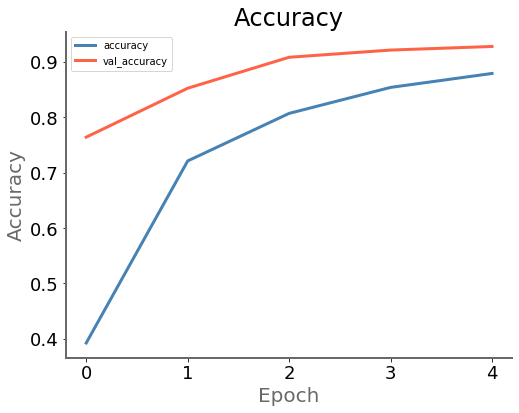

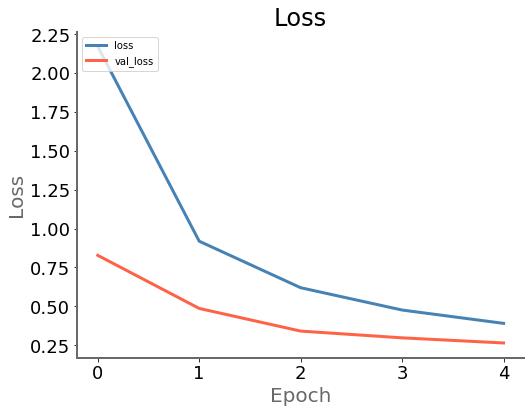

In [13]:
pwk.plot_history(history, save_as='01-history')

## Step 8 - Evaluate best model

### 8.1 - Restore best model :

In [14]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


### 8.2 - Evaluate it :

In [15]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2646
Test accuracy  : 0.9278


**Plot confusion matrix**

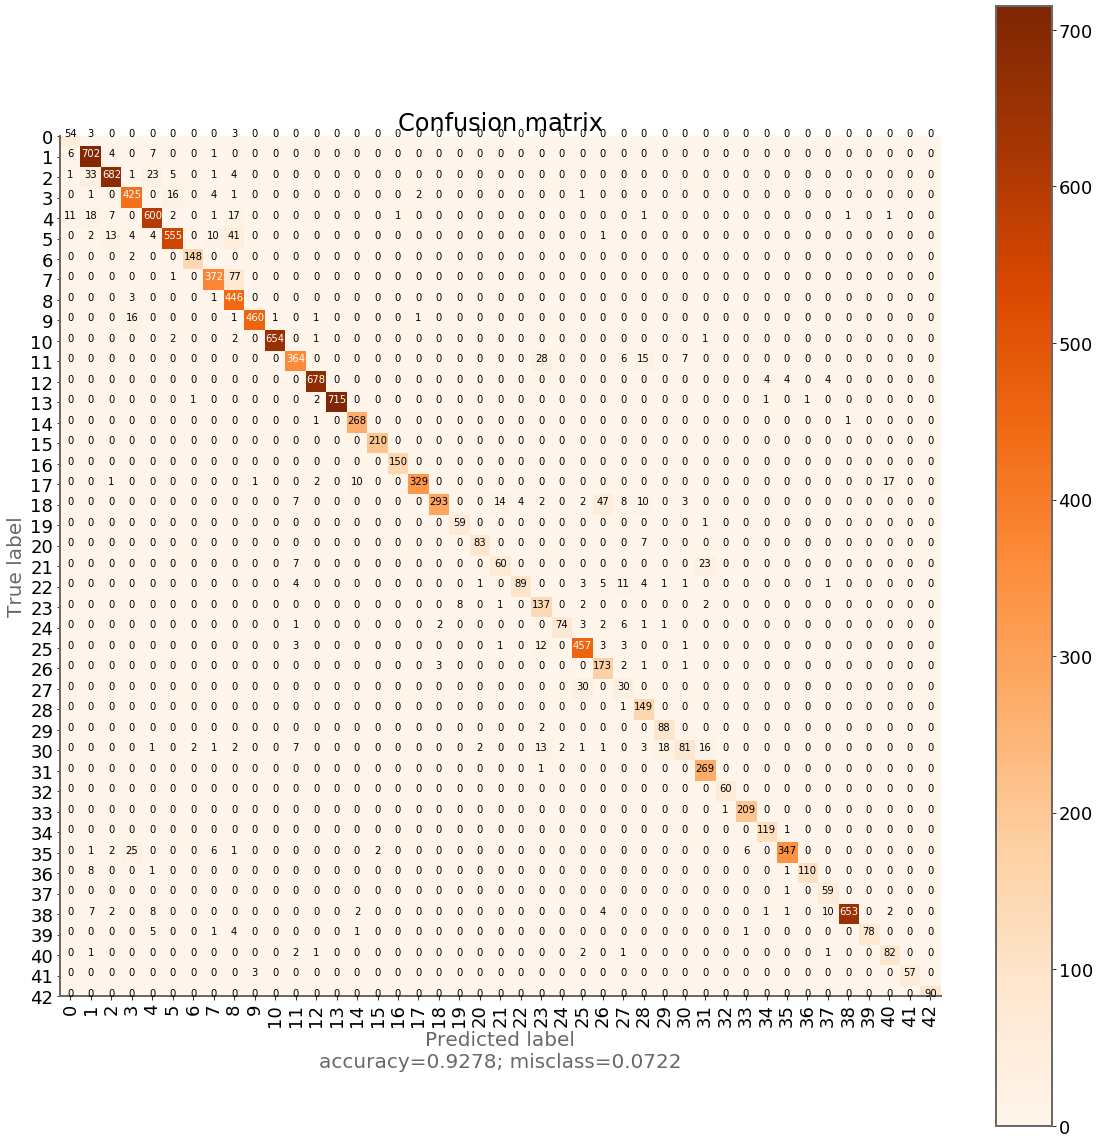

In [16]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

cmap = plt.get_cmap('Oranges')
pwk.plot_confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, cmap=cmap, save_as='02-confusion-matrix')

In [17]:
pwk.end()

End time is : Wednesday 27 January 2021, 18:30:09
Duration is : 00:01:15 837ms
This notebook ends here


<div class="todo">
     What you can do:
    <ul>
        <li>Try different datasets / models</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>What's the best strategy?  How to compare?</li>
    </ul>
    
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>